In [1]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **1. Loading the Data**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#file_path = "./Data/combined_balanced_CEFR_sentences_augmented.csv"
file_path = "./Data/combined_balanced_CEFR_sentences_augmented_A2_and_C2.csv"

# Load your dataset
data = pd.read_csv(file_path)

# Create a new coloumn to store the difficulty labels
data["difficulty_label"] = data["difficulty"]

# Convert difficulty column to numeric labels
data["difficulty"] = data["difficulty"].astype("category").cat.codes


# Display the number of samples in each difficulty category
data["difficulty"].value_counts()

# Display the processed data
display(data.head(10))

# Show the number of duplicated sentences
print("\nNumber of duplicated sentences:", data.duplicated("sentence").sum())

# Show the number of duplicated sentences by difficulty level
if (data.duplicated("sentence").sum() > 0):
    print("\nNumber of duplicated sentences by difficulty level:")
    print(data[data.duplicated("sentence")]["difficulty"].value_counts())

,sentence,difficulty,sentence_length,difficulty_label
0,Sie haben zwei Kinder.,0,4,A1
1,Natürlich gibt es dort auch Pullover.,0,6,A1
2,Eine Polizistin öffnet die Tür.,0,5,A1
3,Dann sieht sie das Papier an.,0,6,A1
4,Ihr Name: Jella Lepman.,0,4,A1
5,Dinas Vater gibt Dina ein Geschenk.,0,6,A1
6,Sandra steigt aus.,0,3,A1
7,Er sucht seinen Platz.,0,4,A1
8,Hannah ist traurig.,0,3,A1
9,Hier sind die Berge sehr hoch.,0,6,A1



Number of duplicated sentences: 0


### **2. Splitting the Dataset**
Here, we split the dataset into training, test sets using an 80%-20% split. Stratification ensures that class distribution is preserved across splits.

In [21]:
# Split the data into train (70%), validation (20%), and test (10%)
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["difficulty"], random_state=42)


print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2524
Test size: 632



### **3. Preparing the Hugging Face Dataset**
In this step, we convert the dataset into the Hugging Face `Dataset` format and create a `DatasetDict` for easier handling in the `transformers` library.

In [22]:
# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_data)
train_dataset = Dataset.from_pandas(train_data)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'sentence_length', 'difficulty_label', '__index_level_0__'],
        num_rows: 2524
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'sentence_length', 'difficulty_label', '__index_level_0__'],
        num_rows: 632
    })
})



### **4. Tokenizing the Dataset**
Here, we load the tokenizer for `xlm-roberta-base` and tokenize the sentences. We also assign numeric labels for classification.

In [23]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Tokenize the dataset and add the `labels` field
def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Assign numeric labels
    tokenized_inputs["labels"] = examples["difficulty"]
    return tokenized_inputs

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True, num_proc=4)  # Use 4 processes


# Debugging: Check tokenized dataset
print(tokenized_datasets["train"][0])

Python(38035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=4):   0%|          | 0/2524 [00:00<?, ? examples/s]

Python(38039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=4):   0%|          | 0/632 [00:00<?, ? examples/s]

Python(38044) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{'sentence': 'Das ist nach wie vor ein großes Problem.', 'difficulty': 3, 'sentence_length': 8, 'difficulty_label': 'B2', '__index_level_0__': 1852, 'input_ids': [0, 1858, 443, 1561, 1225, 1248, 599, 137908, 15649, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 3}



### **5. Loading the Model**
In this step, we load the pre-trained `xlm-roberta-base` model and prepare it for sequence classification by specifying the number of labels.

In [24]:
import torch
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [25]:
from transformers import AutoModelForSequenceClassification

# Define the number of classes
num_classes = len(data["difficulty"].unique())
print(f"Number of classes: {num_classes}")

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=num_classes)

model.to(device) # Move the model to the device

Number of classes: 6


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=


### **6. Setting Up the Trainer**
We define the training arguments and initialize the `Trainer` class, which manages the fine-tuning process. Early stopping is implemented to prevent overfitting.


In [26]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

# Define a data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Adjusted learning rate
    lr_scheduler_type="linear",  # Gradually reduces learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/wb/btfl8bv91b5c253kbpftk1940000gn/T/ipykernel_31659/4216458826.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### **7. Training the Model**
Finally, we start the training process and fine-tune the model for the text classification task.


In [27]:
# Train the model
trainer.train()

  0%|          | 0/1580 [00:00<?, ?it/s]

{'loss': 1.8249, 'grad_norm': 15.01431941986084, 'learning_rate': 9.936708860759493e-06, 'epoch': 0.06}
{'loss': 1.8087, 'grad_norm': 62.764644622802734, 'learning_rate': 9.87341772151899e-06, 'epoch': 0.13}
{'loss': 1.7975, 'grad_norm': 41.06130599975586, 'learning_rate': 9.810126582278482e-06, 'epoch': 0.19}
{'loss': 1.8212, 'grad_norm': 28.538658142089844, 'learning_rate': 9.746835443037975e-06, 'epoch': 0.25}
{'loss': 1.8098, 'grad_norm': 19.98480224609375, 'learning_rate': 9.68354430379747e-06, 'epoch': 0.32}
{'loss': 1.7824, 'grad_norm': 10.13097095489502, 'learning_rate': 9.620253164556963e-06, 'epoch': 0.38}
{'loss': 1.7952, 'grad_norm': 15.267022132873535, 'learning_rate': 9.556962025316456e-06, 'epoch': 0.44}
{'loss': 1.7718, 'grad_norm': 12.045249938964844, 'learning_rate': 9.49367088607595e-06, 'epoch': 0.51}
{'loss': 1.7567, 'grad_norm': 18.430828094482422, 'learning_rate': 9.430379746835444e-06, 'epoch': 0.57}
{'loss': 1.7303, 'grad_norm': 20.728212356567383, 'learning_ra

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.4721397161483765, 'eval_runtime': 14.5722, 'eval_samples_per_second': 43.37, 'eval_steps_per_second': 5.421, 'epoch': 1.0}
{'loss': 1.5068, 'grad_norm': 32.18034362792969, 'learning_rate': 8.987341772151899e-06, 'epoch': 1.01}
{'loss': 1.5017, 'grad_norm': 26.47724723815918, 'learning_rate': 8.924050632911393e-06, 'epoch': 1.08}
{'loss': 1.413, 'grad_norm': 34.712921142578125, 'learning_rate': 8.860759493670886e-06, 'epoch': 1.14}
{'loss': 1.3827, 'grad_norm': 23.06500816345215, 'learning_rate': 8.79746835443038e-06, 'epoch': 1.2}
{'loss': 1.3442, 'grad_norm': 28.872581481933594, 'learning_rate': 8.734177215189874e-06, 'epoch': 1.27}
{'loss': 1.3214, 'grad_norm': 31.99358558654785, 'learning_rate': 8.670886075949367e-06, 'epoch': 1.33}
{'loss': 1.3688, 'grad_norm': 41.75616455078125, 'learning_rate': 8.607594936708861e-06, 'epoch': 1.39}
{'loss': 1.3207, 'grad_norm': 17.353656768798828, 'learning_rate': 8.544303797468356e-06, 'epoch': 1.46}
{'loss': 1.3063, 'grad_norm':

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.120125651359558, 'eval_runtime': 15.1698, 'eval_samples_per_second': 41.662, 'eval_steps_per_second': 5.208, 'epoch': 2.0}
{'loss': 1.1802, 'grad_norm': 28.95848274230957, 'learning_rate': 7.974683544303799e-06, 'epoch': 2.03}
{'loss': 1.151, 'grad_norm': 60.62104034423828, 'learning_rate': 7.911392405063292e-06, 'epoch': 2.09}
{'loss': 1.1607, 'grad_norm': 60.36784362792969, 'learning_rate': 7.848101265822786e-06, 'epoch': 2.15}
{'loss': 1.1246, 'grad_norm': 48.645835876464844, 'learning_rate': 7.78481012658228e-06, 'epoch': 2.22}
{'loss': 1.1845, 'grad_norm': 30.637805938720703, 'learning_rate': 7.721518987341773e-06, 'epoch': 2.28}
{'loss': 1.1651, 'grad_norm': 65.6178970336914, 'learning_rate': 7.658227848101265e-06, 'epoch': 2.34}
{'loss': 1.1501, 'grad_norm': 40.777503967285156, 'learning_rate': 7.5949367088607605e-06, 'epoch': 2.41}
{'loss': 1.0881, 'grad_norm': 80.08983612060547, 'learning_rate': 7.531645569620254e-06, 'epoch': 2.47}
{'loss': 1.0439, 'grad_norm'

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.0745513439178467, 'eval_runtime': 15.4023, 'eval_samples_per_second': 41.033, 'eval_steps_per_second': 5.129, 'epoch': 3.0}
{'loss': 1.0288, 'grad_norm': 72.52366638183594, 'learning_rate': 6.962025316455697e-06, 'epoch': 3.04}
{'loss': 1.0529, 'grad_norm': 42.58641052246094, 'learning_rate': 6.898734177215191e-06, 'epoch': 3.1}
{'loss': 1.0438, 'grad_norm': 48.52302551269531, 'learning_rate': 6.835443037974684e-06, 'epoch': 3.16}
{'loss': 1.0354, 'grad_norm': 52.20246505737305, 'learning_rate': 6.772151898734178e-06, 'epoch': 3.23}
{'loss': 0.9962, 'grad_norm': 92.393310546875, 'learning_rate': 6.708860759493672e-06, 'epoch': 3.29}
{'loss': 1.0216, 'grad_norm': 38.51597595214844, 'learning_rate': 6.645569620253165e-06, 'epoch': 3.35}
{'loss': 0.9815, 'grad_norm': 31.87078285217285, 'learning_rate': 6.582278481012659e-06, 'epoch': 3.42}
{'loss': 0.9541, 'grad_norm': 69.78897094726562, 'learning_rate': 6.518987341772153e-06, 'epoch': 3.48}
{'loss': 1.0417, 'grad_norm': 4

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.0359232425689697, 'eval_runtime': 18.4827, 'eval_samples_per_second': 34.194, 'eval_steps_per_second': 4.274, 'epoch': 4.0}
{'loss': 0.894, 'grad_norm': 26.550582885742188, 'learning_rate': 5.949367088607595e-06, 'epoch': 4.05}
{'loss': 0.9456, 'grad_norm': 77.3869857788086, 'learning_rate': 5.886075949367089e-06, 'epoch': 4.11}
{'loss': 0.9879, 'grad_norm': 77.04312133789062, 'learning_rate': 5.8227848101265824e-06, 'epoch': 4.18}
{'loss': 0.8452, 'grad_norm': 26.112619400024414, 'learning_rate': 5.759493670886076e-06, 'epoch': 4.24}
{'loss': 0.9584, 'grad_norm': 36.376007080078125, 'learning_rate': 5.69620253164557e-06, 'epoch': 4.3}
{'loss': 0.9612, 'grad_norm': 62.91496276855469, 'learning_rate': 5.6329113924050636e-06, 'epoch': 4.37}
{'loss': 0.8864, 'grad_norm': 54.2934455871582, 'learning_rate': 5.569620253164557e-06, 'epoch': 4.43}
{'loss': 0.9386, 'grad_norm': 49.530662536621094, 'learning_rate': 5.506329113924051e-06, 'epoch': 4.49}
{'loss': 0.9748, 'grad_norm

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.022827386856079, 'eval_runtime': 15.9816, 'eval_samples_per_second': 39.546, 'eval_steps_per_second': 4.943, 'epoch': 5.0}
{'loss': 0.8162, 'grad_norm': 40.778419494628906, 'learning_rate': 4.936708860759495e-06, 'epoch': 5.06}
{'loss': 0.8918, 'grad_norm': 48.73004913330078, 'learning_rate': 4.873417721518987e-06, 'epoch': 5.13}
{'loss': 0.8871, 'grad_norm': 34.8919677734375, 'learning_rate': 4.8101265822784815e-06, 'epoch': 5.19}
{'loss': 0.943, 'grad_norm': 29.549150466918945, 'learning_rate': 4.746835443037975e-06, 'epoch': 5.25}
{'loss': 0.9041, 'grad_norm': 45.41377639770508, 'learning_rate': 4.683544303797468e-06, 'epoch': 5.32}
{'loss': 0.7702, 'grad_norm': 39.25462341308594, 'learning_rate': 4.620253164556963e-06, 'epoch': 5.38}
{'loss': 0.7789, 'grad_norm': 64.03059387207031, 'learning_rate': 4.556962025316456e-06, 'epoch': 5.44}
{'loss': 0.8566, 'grad_norm': 32.51564025878906, 'learning_rate': 4.4936708860759495e-06, 'epoch': 5.51}
{'loss': 0.7893, 'grad_norm

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.0325764417648315, 'eval_runtime': 16.0131, 'eval_samples_per_second': 39.468, 'eval_steps_per_second': 4.933, 'epoch': 6.0}
{'loss': 0.8587, 'grad_norm': 68.81144714355469, 'learning_rate': 3.9873417721518995e-06, 'epoch': 6.01}
{'loss': 0.8194, 'grad_norm': 90.506103515625, 'learning_rate': 3.924050632911393e-06, 'epoch': 6.08}
{'loss': 0.7, 'grad_norm': 64.32861328125, 'learning_rate': 3.860759493670886e-06, 'epoch': 6.14}
{'loss': 0.7846, 'grad_norm': 46.11383056640625, 'learning_rate': 3.7974683544303802e-06, 'epoch': 6.2}
{'loss': 0.714, 'grad_norm': 65.54336547851562, 'learning_rate': 3.7341772151898737e-06, 'epoch': 6.27}
{'loss': 0.751, 'grad_norm': 70.98705291748047, 'learning_rate': 3.6708860759493675e-06, 'epoch': 6.33}
{'loss': 0.737, 'grad_norm': 56.921390533447266, 'learning_rate': 3.607594936708861e-06, 'epoch': 6.39}
{'loss': 0.744, 'grad_norm': 37.83836364746094, 'learning_rate': 3.544303797468355e-06, 'epoch': 6.46}
{'loss': 0.796, 'grad_norm': 124.687

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.01034677028656, 'eval_runtime': 16.2154, 'eval_samples_per_second': 38.975, 'eval_steps_per_second': 4.872, 'epoch': 7.0}
{'loss': 0.7392, 'grad_norm': 67.38069152832031, 'learning_rate': 2.9746835443037974e-06, 'epoch': 7.03}
{'loss': 0.7478, 'grad_norm': 54.20924758911133, 'learning_rate': 2.9113924050632912e-06, 'epoch': 7.09}
{'loss': 0.6596, 'grad_norm': 34.30183029174805, 'learning_rate': 2.848101265822785e-06, 'epoch': 7.15}
{'loss': 0.7721, 'grad_norm': 38.946041107177734, 'learning_rate': 2.7848101265822785e-06, 'epoch': 7.22}
{'loss': 0.6685, 'grad_norm': 54.91692352294922, 'learning_rate': 2.7215189873417724e-06, 'epoch': 7.28}
{'loss': 0.7548, 'grad_norm': 59.06230926513672, 'learning_rate': 2.6582278481012658e-06, 'epoch': 7.34}
{'loss': 0.7021, 'grad_norm': 31.7984619140625, 'learning_rate': 2.5949367088607596e-06, 'epoch': 7.41}
{'loss': 0.8103, 'grad_norm': 49.10462951660156, 'learning_rate': 2.5316455696202535e-06, 'epoch': 7.47}
{'loss': 0.7425, 'grad_

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.0225403308868408, 'eval_runtime': 11.0608, 'eval_samples_per_second': 57.139, 'eval_steps_per_second': 7.142, 'epoch': 8.0}
{'loss': 0.6485, 'grad_norm': 64.37227630615234, 'learning_rate': 1.9620253164556965e-06, 'epoch': 8.04}
{'loss': 0.6502, 'grad_norm': 26.780914306640625, 'learning_rate': 1.8987341772151901e-06, 'epoch': 8.1}
{'loss': 0.8096, 'grad_norm': 49.53507614135742, 'learning_rate': 1.8354430379746838e-06, 'epoch': 8.16}
{'loss': 0.7308, 'grad_norm': 77.31842041015625, 'learning_rate': 1.7721518987341774e-06, 'epoch': 8.23}
{'loss': 0.6835, 'grad_norm': 45.03086853027344, 'learning_rate': 1.708860759493671e-06, 'epoch': 8.29}
{'loss': 0.6761, 'grad_norm': 42.104454040527344, 'learning_rate': 1.6455696202531647e-06, 'epoch': 8.35}
{'loss': 0.7636, 'grad_norm': 35.851261138916016, 'learning_rate': 1.5822784810126585e-06, 'epoch': 8.42}
{'loss': 0.632, 'grad_norm': 59.57061004638672, 'learning_rate': 1.518987341772152e-06, 'epoch': 8.48}
{'loss': 0.6723, 'gra

  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.0494251251220703, 'eval_runtime': 15.1723, 'eval_samples_per_second': 41.655, 'eval_steps_per_second': 5.207, 'epoch': 9.0}
{'train_runtime': 3152.27, 'train_samples_per_second': 8.007, 'train_steps_per_second': 0.501, 'train_loss': 1.011397075217149, 'epoch': 9.0}


TrainOutput(global_step=1422, training_loss=1.011397075217149, metrics={'train_runtime': 3152.27, 'train_samples_per_second': 8.007, 'train_steps_per_second': 0.501, 'total_flos': 1494261346940928.0, 'train_loss': 1.011397075217149, 'epoch': 9.0})

### **8. Evaluating the Model**
Evaluate the model on the test set to check its performance using metrics like accuracy, precision, recall, and F1-score.

In [28]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Compute additional metrics if needed
from sklearn.metrics import classification_report

# Extract true labels (y_true) from the test dataset
y_true = test_data["difficulty"].tolist()  # Ensure it's a list of integers

# Predict the labels using the trained model
y_pred = trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=-1)

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


  0%|          | 0/79 [00:00<?, ?it/s]

{'eval_loss': 1.01034677028656, 'eval_runtime': 14.0319, 'eval_samples_per_second': 45.04, 'eval_steps_per_second': 5.63, 'epoch': 9.0}


  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       105
           1       0.54      0.41      0.46       105
           2       0.55      0.57      0.56       105
           3       0.43      0.42      0.43       106
           4       0.48      0.45      0.47       106
           5       0.73      0.70      0.71       105

    accuracy                           0.57       632
   macro avg       0.56      0.57      0.56       632
weighted avg       0.56      0.57      0.56       632



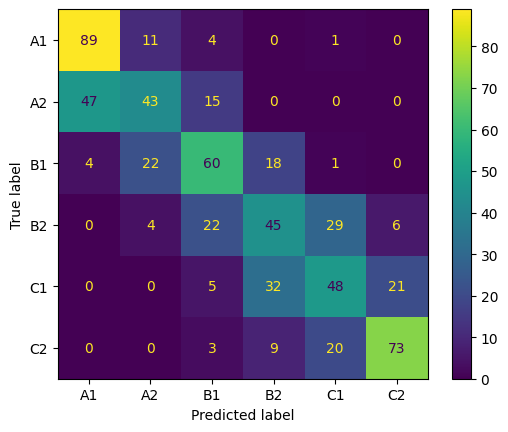

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A1", "A2", "B1", "B2", "C1", "C2"])
disp.plot(cmap="viridis")


In [12]:
model.save_pretrained("./model/xlm-roberta-base-augmented-100-c2-ac-059")
tokenizer.save_pretrained("./model/xlm-roberta-base-augmented-100-c2-ac-059")

('./model/xlm-roberta-base-augmented-100-c2-ac-059/tokenizer_config.json',
 './model/xlm-roberta-base-augmented-100-c2-ac-059/special_tokens_map.json',
 './model/xlm-roberta-base-augmented-100-c2-ac-059/tokenizer.json')